In [4]:
from konlpy.tag import Mecab
from collections import Counter
import tensorflow as tf
import numpy as np
import pandas as pd
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)
mecab = Mecab()

1.3.3
0.5.2
4.1.2


# Load Model & Datast

load word2vec model 

In [245]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_file_path = '/workspace/userdisk/sentiment_classification/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
word_vectors.wv['끝']

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

In [247]:
word_vectors.wv.similar_by_word("끝")

[('마지막', 0.6325399875640869),
 ('결판', 0.5526015758514404),
 ('발목', 0.5465342402458191),
 ('산산조각', 0.5418900847434998),
 ('막바지', 0.5412753820419312),
 ('싫증', 0.5256820917129517),
 ('양쪽', 0.5253474116325378),
 ('무릎', 0.5246764421463013),
 ('후', 0.5051813721656799),
 ('이어진', 0.5038793087005615)]

In [48]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# Data Loader

In [49]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [50]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [116]:
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2 
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}
for i in range(10):
    print(f"{i}: {index_to_word.get(i, '<None>')}")

0: <PAD>
1: <BOS>
2: <UNK>
3: <UNUSED>
4: .
5: 영화
6: 다
7: 고
8: 하
9: 을


# Feature Engineering

데이터셋 내 문장 길이 분포

In [52]:
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


적절한 최대 문장 길이 지정

In [53]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [54]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train.shape, X_test.shape)

(146182, 41) (49157, 41)


# Validation, Train Split

In [56]:
x_val = X_train[:20000]   
y_val = y_train[:20000]
partial_x_train = X_train[20000:]  
partial_y_train = y_train[20000:]

print(partial_x_train.shape, partial_y_train.shape)
print(x_val.shape,y_val.shape)


(126182, 41) (126182,)
(20000, 41) (20000,)


# Model Build

In [166]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Embedding,
    LSTM,Bidirectional,
    Dense,
    Conv1D,
    GlobalMaxPooling1D, MaxPooling1D,
    Input,
    Dropout
)


In [64]:
vocab_size = 10000   
word_vector_dim = 16 
max_len = maxlen

모델1. LSTM

In [167]:
model_lstm = Sequential([
    Embedding(vocab_size, word_vector_dim, input_shape=(None,)),
    LSTM(8),
    Dense(8, activation='relu'),
    Dropout(0.3),  
    Dense(1, activation='sigmoid')
])
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
lstm_11 (LSTM)               (None, 8)                 800       
_________________________________________________________________
dense_36 (Dense)             (None, 8)                 72        
_________________________________________________________________
dropout_76 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


모델 2. CNN 1D

In [168]:
model_cnn = Sequential([
    Embedding(vocab_size, word_vector_dim,  input_shape=(None,)),
    Conv1D(16, 7, activation='relu'),
    MaxPooling1D(5),
    Conv1D(16, 7, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(8, activation='relu'),
    Dropout(0.3), 
    Dense(1, activation='sigmoid')
])

model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 16)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_77 (Dropout)         (None, 8)               

모델 3. Bidirectional LSTM


In [175]:
model_bilstm = Sequential([
    Embedding(vocab_size, word_vector_dim, input_shape=(None,)),
    Bidirectional(LSTM(8)), 
    Dense(8, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_bilstm.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 16)                1600      
_________________________________________________________________
dense_44 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_80 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 9         
Total params: 161,745
Trainable params: 161,745
Non-trainable params: 0
_________________________________________________________________


# Train Model

In [98]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [176]:
checkpoint_lstm = ModelCheckpoint(
    filepath='/workspace/userdisk/sentiment_classification/best_model_lstm.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

checkpoint_cnn = ModelCheckpoint(
    filepath='/workspace/userdisk/sentiment_classification/best_model_cnn.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

checkpoint_bilstm = ModelCheckpoint(
    filepath='/workspace/userdisk/sentiment_classification/best_model_bilstm.keras',    
    monitor='val_loss',             
    save_best_only=True,                     
    verbose=1
)


In [171]:
history_lstm = model_lstm.fit(
    partial_x_train, partial_y_train,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=128,
    verbose = 2,
    callbacks=[checkpoint_lstm]
)

Epoch 1/20
986/986 - 6s - loss: 0.4949 - accuracy: 0.7964 - val_loss: 0.4187 - val_accuracy: 0.8378

Epoch 00001: val_loss improved from inf to 0.41869, saving model to /workspace/userdisk/sentiment_classification/best_model_lstm.keras
Epoch 2/20
986/986 - 4s - loss: 0.3853 - accuracy: 0.8526 - val_loss: 0.3741 - val_accuracy: 0.8493

Epoch 00002: val_loss improved from 0.41869 to 0.37415, saving model to /workspace/userdisk/sentiment_classification/best_model_lstm.keras
Epoch 3/20
986/986 - 4s - loss: 0.3431 - accuracy: 0.8677 - val_loss: 0.3602 - val_accuracy: 0.8530

Epoch 00003: val_loss improved from 0.37415 to 0.36023, saving model to /workspace/userdisk/sentiment_classification/best_model_lstm.keras
Epoch 4/20
986/986 - 4s - loss: 0.3146 - accuracy: 0.8788 - val_loss: 0.3612 - val_accuracy: 0.8540

Epoch 00004: val_loss did not improve from 0.36023
Epoch 5/20
986/986 - 4s - loss: 0.2961 - accuracy: 0.8862 - val_loss: 0.3672 - val_accuracy: 0.8483

Epoch 00005: val_loss did not i

In [172]:
history_cnn = model_cnn.fit(
    partial_x_train, partial_y_train,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=128,
    verbose = 2,
    callbacks=[checkpoint_cnn]
)

Epoch 1/20
986/986 - 4s - loss: 0.4356 - accuracy: 0.7962 - val_loss: 0.3396 - val_accuracy: 0.8502

Epoch 00001: val_loss improved from inf to 0.33963, saving model to /workspace/userdisk/sentiment_classification/best_model_cnn.keras
Epoch 2/20
986/986 - 4s - loss: 0.3308 - accuracy: 0.8683 - val_loss: 0.3287 - val_accuracy: 0.8603

Epoch 00002: val_loss improved from 0.33963 to 0.32868, saving model to /workspace/userdisk/sentiment_classification/best_model_cnn.keras
Epoch 3/20
986/986 - 4s - loss: 0.2877 - accuracy: 0.8889 - val_loss: 0.3317 - val_accuracy: 0.8579

Epoch 00003: val_loss did not improve from 0.32868
Epoch 4/20
986/986 - 4s - loss: 0.2471 - accuracy: 0.9086 - val_loss: 0.3572 - val_accuracy: 0.8563

Epoch 00004: val_loss did not improve from 0.32868
Epoch 5/20
986/986 - 4s - loss: 0.2085 - accuracy: 0.9270 - val_loss: 0.3924 - val_accuracy: 0.8502

Epoch 00005: val_loss did not improve from 0.32868
Epoch 6/20
986/986 - 4s - loss: 0.1765 - accuracy: 0.9407 - val_loss: 

In [177]:
history_bilstm = model_bilstm.fit(
    partial_x_train, partial_y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=128,
    callbacks=[checkpoint_bilstm],
    verbose=2
)

Epoch 1/10
986/986 - 9s - loss: 0.4305 - accuracy: 0.8077 - val_loss: 0.3481 - val_accuracy: 0.8486

Epoch 00001: val_loss improved from inf to 0.34811, saving model to /workspace/userdisk/sentiment_classification/best_model_bilstm.keras
Epoch 2/10
986/986 - 6s - loss: 0.3493 - accuracy: 0.8572 - val_loss: 0.3410 - val_accuracy: 0.8485

Epoch 00002: val_loss improved from 0.34811 to 0.34098, saving model to /workspace/userdisk/sentiment_classification/best_model_bilstm.keras
Epoch 3/10
986/986 - 6s - loss: 0.3234 - accuracy: 0.8676 - val_loss: 0.3377 - val_accuracy: 0.8548

Epoch 00003: val_loss improved from 0.34098 to 0.33766, saving model to /workspace/userdisk/sentiment_classification/best_model_bilstm.keras
Epoch 4/10
986/986 - 6s - loss: 0.3022 - accuracy: 0.8752 - val_loss: 0.3442 - val_accuracy: 0.8546

Epoch 00004: val_loss did not improve from 0.33766
Epoch 5/10
986/986 - 6s - loss: 0.2812 - accuracy: 0.8837 - val_loss: 0.3516 - val_accuracy: 0.8517

Epoch 00005: val_loss did

# 학습 결과 시각화

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, title='Model'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy 그래프
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

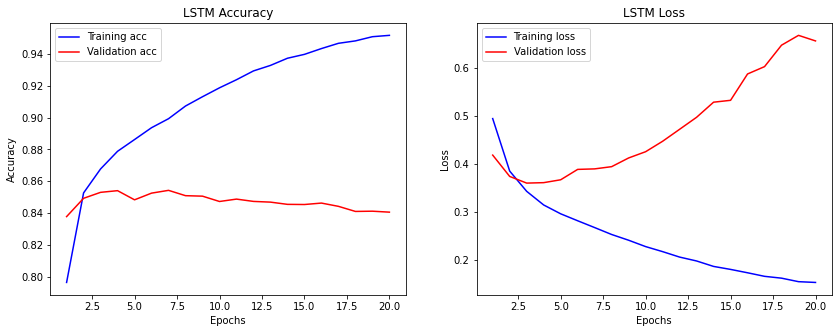

In [178]:
plot_history(history_lstm, title='LSTM')

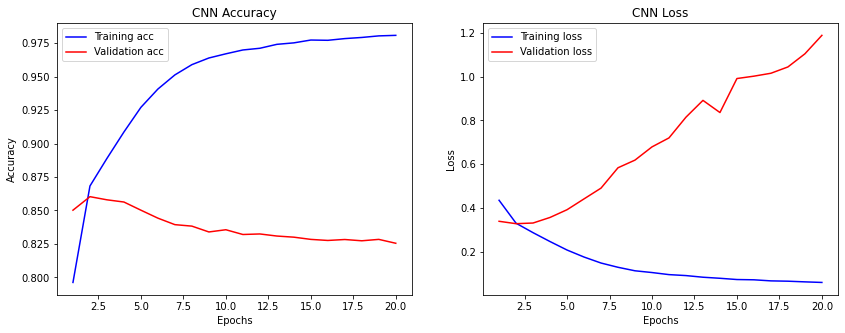

In [179]:
plot_history(history_cnn, title='CNN')

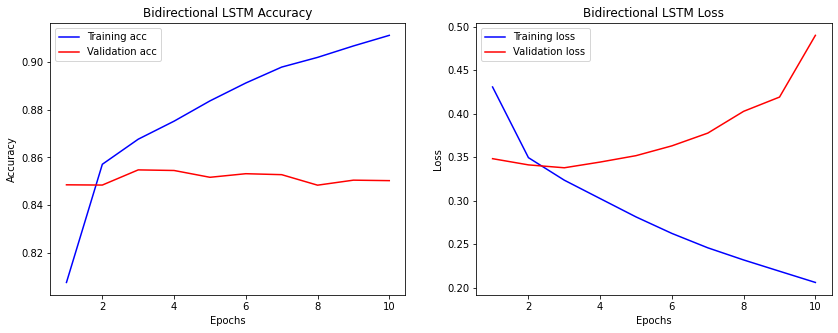

In [180]:
plot_history(history_bilstm, title='Bidirectional LSTM')

# Best Model Test

In [181]:
from tensorflow.keras.models import load_model

best_lstm = load_model('/workspace/userdisk/sentiment_classification/best_model_lstm.keras')
best_cnn = load_model('/workspace/userdisk/sentiment_classification/best_model_cnn.keras')
best_bilstm =load_model('/workspace/userdisk/sentiment_classification/best_model_bilstm.keras')

In [182]:
results_lstm = best_lstm.evaluate(X_test,  y_test, verbose=2)
print(results_lstm)

1537/1537 - 3s - loss: 0.3695 - accuracy: 0.8487
[0.36949464678764343, 0.8486889004707336]


In [183]:
results_cnn = best_cnn.evaluate(X_test,  y_test, verbose=2)
print(results_cnn)

1537/1537 - 2s - loss: 0.3379 - accuracy: 0.8550
[0.3378945589065552, 0.8549748659133911]


In [186]:
results_bilstm = best_bilstm.evaluate(X_test,  y_test, verbose=2)
print(results_bilstm)

1537/1537 - 4s - loss: 0.3433 - accuracy: 0.8494
[0.34334877133369446, 0.8494415879249573]


- 세 모델 모두 비슷한 정도의 accuracy 성능을 보임
- cnn 에서는 85 이상 accuracy 나옴
- cnn>bilstm>lstm 

# Word2Vec로 학습된 임베딩 레이어 확인

In [223]:
import os
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras import regularizers

def save_embedding_weights(model, word_to_index, index_to_word, word_vector_dim, vocab_size, save_path):
    """
    학습된 임베딩 가중치를 Word2Vec 텍스트 포맷으로 저장함
    """
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    with open(save_path, 'w') as f:
        f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) 
        
        # 임베딩 레이어 추출 (첫 번째 레이어 기준)
        vectors = model.get_weights()[0]
        
        for i in range(4,vocab_size):
            f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
        f.close()

    print(f"✅ 임베딩 벡터 저장 완료: {save_path}")

def save_all_model_embeddings(models_dict, word_to_index, index_to_word, word_vector_dim, vocab_size, base_path):
    """
    여러 모델의 임베딩을 반복적으로 저장
    """
    os.makedirs(base_path, exist_ok=True)

    for name, model in models_dict.items():
        save_path = os.path.join(base_path, f"w2v_{name}.txt")
        save_embedding_weights(model, word_to_index, index_to_word, word_vector_dim, vocab_size, save_path)
        
        
def print_similar_words(word_vectors, query_word, topn=10):
    """
    주어진 단어에 대해 Word2Vec 모델에서 가장 유사한 단어를 출력한다
    """
    if query_word not in word_vectors:
        print(f"❌ '{query_word}' 단어는 임베딩 사전에 없습니다.")
        return

    print(f"\n[ {query_word} ] 와 유사한 단어 Top {topn}:\n")
    for word, score in word_vectors.similar_by_word(query_word, topn=topn):
        print(f"  {word:10s} | 유사도: {score:.4f}")

    

In [361]:
save_all_model_embeddings(
    models_dict={
        "lstm": best_lstm,
        "bilstm": best_bilstm,
        "cnn_emb": best_cnn
    },
    word_to_index=word_to_index,
    index_to_word=index_to_word,
    word_vector_dim=16,
    vocab_size=vocab_size,
    base_path="/workspace/userdisk/sentiment_classification"
)

✅ 임베딩 벡터 저장 완료: /workspace/userdisk/sentiment_classification/w2v_lstm.txt
✅ 임베딩 벡터 저장 완료: /workspace/userdisk/sentiment_classification/w2v_bilstm.txt
✅ 임베딩 벡터 저장 완료: /workspace/userdisk/sentiment_classification/w2v_cnn_emb.txt


In [362]:
# 저장된 모델별 임베딩 불러오기
word_vectors_lstm_ =  Word2VecKeyedVectors.load_word2vec_format(
    "/workspace/userdisk/sentiment_classification/w2v_lstm.txt", binary=False
)

word_vectors_bilstm_ = Word2VecKeyedVectors.load_word2vec_format(
    "/workspace/userdisk/sentiment_classification/w2v_bilstm.txt", binary=False
)

word_vectors_cnn_ = Word2VecKeyedVectors.load_word2vec_format(
    "/workspace/userdisk/sentiment_classification/w2v_cnn.txt", binary=False
)

In [363]:
print("LSTM")
print_similar_words(word_vectors_lstm_, "스토리")

print("\nBiLSTM")
print_similar_words(word_vectors_bilstm_, "스토리")

print("\nCNN")
print_similar_words(word_vectors_cnn_, "스토리")


LSTM

[ 스토리 ] 와 유사한 단어 Top 10:

  유혼         | 유사도: 0.7656
  컨데         | 유사도: 0.7455
  성질         | 유사도: 0.7385
  라구         | 유사도: 0.7372
  잠자         | 유사도: 0.7347
  관람객        | 유사도: 0.7283
  허무맹랑       | 유사도: 0.7193
  늘          | 유사도: 0.7171
  이이         | 유사도: 0.7167
  死          | 유사도: 0.7159

BiLSTM

[ 스토리 ] 와 유사한 단어 Top 10:

  주저         | 유사도: 0.9303
  뭔지         | 유사도: 0.9147
  김신         | 유사도: 0.9097
  사태         | 유사도: 0.9054
  해소         | 유사도: 0.9047
  이득         | 유사도: 0.9014
  아앙         | 유사도: 0.8999
  삼총사        | 유사도: 0.8991
  미리         | 유사도: 0.8975
  ~~~~~~~    | 유사도: 0.8967

CNN

[ 스토리 ] 와 유사한 단어 Top 10:

  어지간히       | 유사도: 0.8368
  오타쿠        | 유사도: 0.8312
  영환         | 유사도: 0.8274
  영          | 유사도: 0.8189
  버렸         | 유사도: 0.8143
  피우         | 유사도: 0.8061
  그린         | 유사도: 0.8043
  정직         | 유사도: 0.8018
  지어다        | 유사도: 0.8016
  내고         | 유사도: 0.7996


- 훈련 데이터에 의해 크게 영향받은 것으로 보임.
- 따라서 일반화되지 않은 결과를 보이고 있다.

# Word2Vec 활용하여 성능 향상하기

Word 2 Vec Embadding Layer

In [308]:
word_vector_dim = 100

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]
        
from tensorflow.keras.initializers import Constant
embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=word_vector_dim,
    embeddings_initializer=Constant(embedding_matrix),  # Word2Vec으로 초기화
    input_shape=(None,),
    trainable=True
)

New CheckPoint

In [309]:
checkpoint_lstm_w2v = ModelCheckpoint(
    filepath='/workspace/userdisk/sentiment_classification/best_model_lstm_w2v.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

checkpoint_cnn_w2v = ModelCheckpoint(
    filepath='/workspace/userdisk/sentiment_classification/best_model_cnn_w2v.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

checkpoint_bilstm_w2v = ModelCheckpoint(
    filepath='/workspace/userdisk/sentiment_classification/best_model_bilstm_w2v.keras',    
    monitor='val_loss',             
    save_best_only=True,                     
    verbose=1
)


Build Model

- 기존 모델과 동일하게 사용했더니 오히려 성능이 나빠졌다.
- 모델에 들어가는 임베딩 크기가 커졌기 때문에 모델도 키워줘야 성능이 좋아지는 것 같다.
- 여러번 실험해도 epoch 10 이상은 완벽하게 오버피팅이 나서 에폭 줄임


In [320]:
model_lstm_w2v = Sequential([
    embedding_layer,
    LSTM(128),
    Dense(1, activation='sigmoid')
])
model_lstm_w2v.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm_w2v.summary()

Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, None, 100)         1000000   
_________________________________________________________________
lstm_49 (LSTM)               (None, 128)               117248    
_________________________________________________________________
dense_146 (Dense)            (None, 1)                 129       
Total params: 1,117,377
Trainable params: 1,117,377
Non-trainable params: 0
_________________________________________________________________


In [321]:
model_cnn_w2v = Sequential([
    embedding_layer,
    Conv1D(128, 7, activation='relu'),
    MaxPooling1D(5),
    Conv1D(64, 7, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(1, activation='sigmoid')
])

model_cnn_w2v.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cnn_w2v.summary()

Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, None, 100)         1000000   
_________________________________________________________________
conv1d_49 (Conv1D)           (None, None, 128)         89728     
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, None, 128)         0         
_________________________________________________________________
conv1d_50 (Conv1D)           (None, None, 64)          57408     
_________________________________________________________________
global_max_pooling1d_26 (Glo (None, 64)                0         
_________________________________________________________________
dense_147 (Dense)            (None, 1)                 65        
Total params: 1,147,201
Trainable params: 1,147,201
Non-trainable params: 0
___________________________________________

In [341]:
model_bilstm_w2v = Sequential([
    embedding_layer,
    Bidirectional(LSTM(256)), 
    Dense(1, activation='sigmoid')
])

model_bilstm_w2v.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_bilstm_w2v.summary()

Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, None, 100)         1000000   
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 512)               731136    
_________________________________________________________________
dense_156 (Dense)            (None, 1)                 513       
Total params: 1,731,649
Trainable params: 1,731,649
Non-trainable params: 0
_________________________________________________________________


Train

In [312]:
history_lstm_w2v = model_lstm_w2v.fit(
    partial_x_train, partial_y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=128,
    verbose = 2,
    callbacks=[checkpoint_lstm_w2v]
)

Epoch 1/10
986/986 - 7s - loss: 0.4184 - accuracy: 0.8058 - val_loss: 0.3453 - val_accuracy: 0.8460

Epoch 00001: val_loss improved from inf to 0.34526, saving model to /workspace/userdisk/sentiment_classification/best_model_lstm_w2v.keras
Epoch 2/10
986/986 - 5s - loss: 0.3103 - accuracy: 0.8669 - val_loss: 0.3172 - val_accuracy: 0.8635

Epoch 00002: val_loss improved from 0.34526 to 0.31716, saving model to /workspace/userdisk/sentiment_classification/best_model_lstm_w2v.keras
Epoch 3/10
986/986 - 5s - loss: 0.2671 - accuracy: 0.8879 - val_loss: 0.3166 - val_accuracy: 0.8638

Epoch 00003: val_loss improved from 0.31716 to 0.31656, saving model to /workspace/userdisk/sentiment_classification/best_model_lstm_w2v.keras
Epoch 4/10
986/986 - 5s - loss: 0.2332 - accuracy: 0.9038 - val_loss: 0.3183 - val_accuracy: 0.8655

Epoch 00004: val_loss did not improve from 0.31656
Epoch 5/10
986/986 - 5s - loss: 0.2032 - accuracy: 0.9186 - val_loss: 0.3311 - val_accuracy: 0.8659

Epoch 00005: val_lo

In [322]:
history_cnn_w2v = model_cnn_w2v.fit(
    partial_x_train, partial_y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=128,
    verbose = 2,
    callbacks=[checkpoint_cnn_w2v]
)

Epoch 1/10
986/986 - 5s - loss: 0.3615 - accuracy: 0.8372 - val_loss: 0.3413 - val_accuracy: 0.8511

Epoch 00001: val_loss improved from 0.69313 to 0.34127, saving model to /workspace/userdisk/sentiment_classification/best_model_cnn_w2v.keras
Epoch 2/10
986/986 - 4s - loss: 0.2619 - accuracy: 0.8909 - val_loss: 0.3351 - val_accuracy: 0.8566

Epoch 00002: val_loss improved from 0.34127 to 0.33508, saving model to /workspace/userdisk/sentiment_classification/best_model_cnn_w2v.keras
Epoch 3/10
986/986 - 4s - loss: 0.2250 - accuracy: 0.9083 - val_loss: 0.3619 - val_accuracy: 0.8554

Epoch 00003: val_loss did not improve from 0.33508
Epoch 4/10
986/986 - 4s - loss: 0.1917 - accuracy: 0.9232 - val_loss: 0.3908 - val_accuracy: 0.8583

Epoch 00004: val_loss did not improve from 0.33508
Epoch 5/10
986/986 - 4s - loss: 0.1584 - accuracy: 0.9373 - val_loss: 0.4177 - val_accuracy: 0.8547

Epoch 00005: val_loss did not improve from 0.33508
Epoch 6/10
986/986 - 4s - loss: 0.1293 - accuracy: 0.9501 

In [342]:
history_bilstm_w2v = model_bilstm_w2v.fit(
    partial_x_train, partial_y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[checkpoint_bilstm_w2v],
    verbose=2
)

Epoch 1/10
1972/1972 - 21s - loss: 0.2071 - accuracy: 0.9141 - val_loss: 0.4250 - val_accuracy: 0.8567

Epoch 00001: val_loss did not improve from 0.32062
Epoch 2/10
1972/1972 - 19s - loss: 0.1312 - accuracy: 0.9481 - val_loss: 0.4627 - val_accuracy: 0.8513

Epoch 00002: val_loss did not improve from 0.32062
Epoch 3/10
1972/1972 - 19s - loss: 0.0985 - accuracy: 0.9622 - val_loss: 0.5623 - val_accuracy: 0.8547

Epoch 00003: val_loss did not improve from 0.32062
Epoch 4/10
1972/1972 - 19s - loss: 0.0740 - accuracy: 0.9723 - val_loss: 0.6388 - val_accuracy: 0.8551

Epoch 00004: val_loss did not improve from 0.32062
Epoch 5/10
1972/1972 - 19s - loss: 0.0561 - accuracy: 0.9791 - val_loss: 0.7404 - val_accuracy: 0.8538

Epoch 00005: val_loss did not improve from 0.32062
Epoch 6/10
1972/1972 - 19s - loss: 0.0437 - accuracy: 0.9835 - val_loss: 0.7946 - val_accuracy: 0.8504

Epoch 00006: val_loss did not improve from 0.32062
Epoch 7/10
1972/1972 - 19s - loss: 0.0339 - accuracy: 0.9874 - val_los

모델 평가

In [324]:
from tensorflow.keras.models import load_model

best_lstm_w2v = load_model('/workspace/userdisk/sentiment_classification/best_model_lstm_w2v.keras')
best_cnn_w2v = load_model('/workspace/userdisk/sentiment_classification/best_model_cnn_w2v.keras')
best_bilstm_w2v =load_model('/workspace/userdisk/sentiment_classification/best_model_bilstm_w2v.keras')

results_lstm_w2v = best_lstm_w2v.evaluate(X_test,  y_test, verbose=2)
print(results_lstm_w2v)
results_bilstm_w2v= best_bilstm_w2v.evaluate(X_test,  y_test, verbose=2)
print(results_bilstm_w2v)
results_cnn_w2v = best_cnn_w2v.evaluate(X_test,  y_test, verbose=2)
print(results_cnn_w2v)

1537/1537 - 4s - loss: 0.3230 - accuracy: 0.8612
[0.3229607343673706, 0.8611794710159302]
1537/1537 - 5s - loss: 0.3238 - accuracy: 0.8623
[0.32383665442466736, 0.8623390197753906]
1537/1537 - 3s - loss: 0.3416 - accuracy: 0.8541
[0.3416331112384796, 0.8540797829627991]


## 최종 모델 Summary

In [349]:
best_bilstm_w2v.summary()
best_lstm_w2v.summary()
best_cnn_w2v.summary()

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, None, 100)         1000000   
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 256)               234496    
_________________________________________________________________
dense_139 (Dense)            (None, 1)                 257       
Total params: 1,234,753
Trainable params: 1,234,753
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, None, 100)         1000000   
_________________________________________________________________
lstm_45 (LSTM)               (None, 128)               117248    
____________________

- word2vec 적용 이전 CNN-1d에서 85.5% ACC 달성함
- word2vec 적용 후  CNN-1d에서 86.23%% ACC 달성함
- 전체적으로 성능 소폭 오름

## 임베딩 비교

In [347]:
save_all_model_embeddings(
    models_dict={
        "lstm_emb": best_lstm_w2v,
        "bilstm_emb": best_bilstm_w2v,
        "cnn_emb": best_cnn_w2v
    },
    word_to_index=word_to_index,
    index_to_word=index_to_word,
    word_vector_dim=word_vector_dim,
    vocab_size=vocab_size,
    base_path="/workspace/userdisk/sentiment_classification"
)

✅ 임베딩 벡터 저장 완료: /workspace/userdisk/sentiment_classification/w2v_lstm_emb.txt
✅ 임베딩 벡터 저장 완료: /workspace/userdisk/sentiment_classification/w2v_bilstm_emb.txt
✅ 임베딩 벡터 저장 완료: /workspace/userdisk/sentiment_classification/w2v_cnn_emb.txt


In [352]:
# 저장된 모델별 임베딩 불러오기
word_vectors_lstm =  Word2VecKeyedVectors.load_word2vec_format(
    "/workspace/userdisk/sentiment_classification/w2v_lstm_emb.txt", binary=False
)

word_vectors_bilstm = Word2VecKeyedVectors.load_word2vec_format(
    "/workspace/userdisk/sentiment_classification/w2v_bilstm_emb.txt", binary=False
)

word_vectors_cnn = Word2VecKeyedVectors.load_word2vec_format(
    "/workspace/userdisk/sentiment_classification/w2v_cnn_emb.txt", binary=False
)

Pretrained embadding 사용 전

In [365]:
print("LSTM")
print_similar_words(word_vectors_lstm_, "스토리")

print("\nBiLSTM")
print_similar_words(word_vectors_bilstm_, "스토리")

print("\nCNN")
print_similar_words(word_vectors_cnn_, "스토리")


LSTM

[ 스토리 ] 와 유사한 단어 Top 10:

  유혼         | 유사도: 0.7656
  컨데         | 유사도: 0.7455
  성질         | 유사도: 0.7385
  라구         | 유사도: 0.7372
  잠자         | 유사도: 0.7347
  관람객        | 유사도: 0.7283
  허무맹랑       | 유사도: 0.7193
  늘          | 유사도: 0.7171
  이이         | 유사도: 0.7167
  死          | 유사도: 0.7159

BiLSTM

[ 스토리 ] 와 유사한 단어 Top 10:

  주저         | 유사도: 0.9303
  뭔지         | 유사도: 0.9147
  김신         | 유사도: 0.9097
  사태         | 유사도: 0.9054
  해소         | 유사도: 0.9047
  이득         | 유사도: 0.9014
  아앙         | 유사도: 0.8999
  삼총사        | 유사도: 0.8991
  미리         | 유사도: 0.8975
  ~~~~~~~    | 유사도: 0.8967

CNN

[ 스토리 ] 와 유사한 단어 Top 10:

  어지간히       | 유사도: 0.8368
  오타쿠        | 유사도: 0.8312
  영환         | 유사도: 0.8274
  영          | 유사도: 0.8189
  버렸         | 유사도: 0.8143
  피우         | 유사도: 0.8061
  그린         | 유사도: 0.8043
  정직         | 유사도: 0.8018
  지어다        | 유사도: 0.8016
  내고         | 유사도: 0.7996


W2V embadding finetunned 이후

In [357]:
print("LSTM")
print_similar_words(word_vectors_lstm, "스토리")

print("\nBiLSTM")
print_similar_words(word_vectors_bilstm, "스토리")

print("\nCNN")
print_similar_words(word_vectors_cnn, "스토리")


LSTM

[ 스토리 ] 와 유사한 단어 Top 10:

  줄거리        | 유사도: 0.7550
  시나리오       | 유사도: 0.7318
  캐릭터        | 유사도: 0.7208
  어드벤처       | 유사도: 0.6652
  엔딩         | 유사도: 0.6575
  아바타        | 유사도: 0.6545
  판타지        | 유사도: 0.6545
  코믹         | 유사도: 0.6485
  유머         | 유사도: 0.6480
  플레이        | 유사도: 0.6461

BiLSTM

[ 스토리 ] 와 유사한 단어 Top 10:

  줄거리        | 유사도: 0.7532
  시나리오       | 유사도: 0.7366
  캐릭터        | 유사도: 0.7078
  어드벤처       | 유사도: 0.6641
  판타지        | 유사도: 0.6612
  에피소드       | 유사도: 0.6548
  엔딩         | 유사도: 0.6524
  코믹         | 유사도: 0.6456
  플레이        | 유사도: 0.6445
  유머         | 유사도: 0.6362

CNN

[ 스토리 ] 와 유사한 단어 Top 10:

  줄거리        | 유사도: 0.7372
  시나리오       | 유사도: 0.7310
  캐릭터        | 유사도: 0.6969
  판타지        | 유사도: 0.6727
  에피소드       | 유사도: 0.6653
  엔딩         | 유사도: 0.6450
  어드벤처       | 유사도: 0.6449
  코믹         | 유사도: 0.6422
  플레이        | 유사도: 0.6420
  라이프        | 유사도: 0.6412


- word2vec를 사용하기 이전에는 특정 배우, 스토리에 대한 일반적이지 않은 상세 속성(허무맹랑,오타쿠,물, 유작 ...)이 유사도가 높게 측정되었다.
- 사용 이후 pretrained된 결과 스토리의 일반적인 속성, 유의어 단어에 대한 유사도가 높게 측정되었다. 

- 분류성능에서 매우 큰 변화를 보이지는 않았으나, word2vec를 적용한 후 조금 더 광범위하고 일반적인 특성을 잘 반영하고 있는 임베딩을 사용할 수 있었다.

# 회고

- 임베딩 적용 후 feature크기가 많아졌으니 당연히 모델이 커져야 된다는 생각을 하지 못했었다. 이것저것 시도하다가 모델 사이즈를 키우니까 학습이 잘되었다. 

